# Librerias

In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram
import math
import librosa
import scipy.signal
import os
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.signal
from torch.utils.data import Dataset, DataLoader, random_split
from collections import defaultdict
import torchaudio.transforms as T
import torch.nn.functional as F
from scipy.signal import resample
from tqdm import tqdm
from geomloss import SamplesLoss
import os
import time
from tqdm import tqdm
import csv
import geomloss
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Configuración inicial para generar dataset sinteticos

In [2]:
base_path = "./features/time_domain_win_cut_pad/"
categories = ["chew", "elpp", "shiv"]
file_limit = 4266  
grouped_files = defaultdict(list)

if not os.path.exists(base_path):
    print(f"Error: Directory '{base_path}' not found.")
    exit()

print(f"Scanning directory: {base_path}\n")

for root, dirs, files in os.walk(base_path):
    folder_name = os.path.basename(root)
    
    if folder_name in categories:
        print(f"Processing folder: {folder_name}, Found {len(files)} files.")

        for file in files:
            if file.endswith(".pt") and len(grouped_files[folder_name]) < file_limit:
                file_path = os.path.join(root, file)
                grouped_files[folder_name].append(file_path)
                print(f"Added {file} to category '{folder_name}'")

Scanning directory: ./features/time_domain_win_cut_pad/

Processing folder: chew, Found 4266 files.
Added C3-CZ_0.0_21.0048.pt to category 'chew'
Added C3-CZ_0.2405_2.5624.pt to category 'chew'
Added C3-CZ_10.4038_12.6573.pt to category 'chew'
Added C3-CZ_100.0431_110.1627.pt to category 'chew'
Added C3-CZ_1002.0443_1005.8908.pt to category 'chew'
Added C3-CZ_1007.3117_1010.1994.pt to category 'chew'
Added C3-CZ_1026.2655_1029.0685.pt to category 'chew'
Added C3-CZ_105.0722_110.9278.pt to category 'chew'
Added C3-CZ_105.7222_115.6.pt to category 'chew'
Added C3-CZ_1067.0648_1079.0259.pt to category 'chew'
Added C3-CZ_1086.1008_1120.6059.pt to category 'chew'
Added C3-CZ_1130.2026_1142.4228.pt to category 'chew'
Added C3-CZ_114.0141_129.7887.pt to category 'chew'
Added C3-CZ_114.0481_119.7789.pt to category 'chew'
Added C3-CZ_115.0957_119.5215.pt to category 'chew'
Added C3-CZ_115.2294_179.9893.pt to category 'chew'
Added C3-CZ_1152.0601_1154.6503.pt to category 'chew'
Added C3-CZ_116.1

In [3]:
chew_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['chew']], axis=0)
elpp_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['elpp']], axis=0)
shiv_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['shiv']], axis=0)

In [4]:
print(chew_data.shape)
print(elpp_data.shape)
print(shiv_data.shape)

(4266, 512)
(156, 512)
(2762, 512)


In [5]:
EEG_PATH = 'data'
EOG_ALL_EPOCHS = 'EOG_all_epochs.npy'
EMG_ALL_EPOCHS = 'EMG_all_epochs.npy'
EEG_ALL_EPOCHS = 'EEG_all_epochs.npy'

In [6]:
def show_data_informations(signal, signal_type):
    print(f"Data type {signal_type}:", type(signal))
    print(f"Data shape {signal_type}:", signal.shape)

In [7]:
eog_data = np.load(os.path.join(EEG_PATH, EOG_ALL_EPOCHS))
emg_data = np.load(os.path.join(EEG_PATH, EMG_ALL_EPOCHS))
eeg_data = np.load(os.path.join(EEG_PATH, EEG_ALL_EPOCHS))

show_data_informations(eog_data, 'EOG')
show_data_informations(emg_data, 'EMG')
show_data_informations(eeg_data, 'EEG')

Data type EOG: <class 'numpy.ndarray'>
Data shape EOG: (3400, 512)
Data type EMG: <class 'numpy.ndarray'>
Data shape EMG: (5598, 512)
Data type EEG: <class 'numpy.ndarray'>
Data shape EEG: (4514, 512)


In [8]:
def get_rms(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records))

def random_signal(signal, combine_num):
    random_result=[]
    for i in range(combine_num):
        random_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[random_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0],signal.shape[1])
        random_result.append(shuffled_dataset)
    random_result  = np.array(random_result)
    return  random_result

In [9]:
EEG_all_random = np.squeeze(random_signal(signal=eeg_data, combine_num=1))

NOISE_all_random_chew = np.squeeze(random_signal(signal=chew_data, combine_num=1))
NOISE_all_random_elpp = np.squeeze(random_signal(signal=elpp_data, combine_num=1))
NOISE_all_random_shiv = np.squeeze(random_signal(signal=shiv_data, combine_num=1))
NOISE_all_random_eog = np.squeeze(random_signal(signal=eog_data, combine_num=1))
NOISE_all_random_emg = np.squeeze(random_signal(signal=emg_data, combine_num=1))

In [10]:
SNR_dB_chew = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_elpp = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_shiv = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_eog = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_emg = np.random.uniform(-7, 2, (eeg_data.shape[0]))

In [11]:
SNR_chew = 10 ** (0.1 * SNR_dB_chew)
SNR_elpp = 10 ** (0.1 * SNR_dB_elpp)
SNR_shiv = 10 ** (0.1 * SNR_dB_shiv)
SNR_eog = 10 ** (0.1 * SNR_dB_eog)
SNR_emg = 10 ** (0.1 * SNR_dB_emg)

In [12]:
num_eeg_samples = EEG_all_random.shape[0]
num_chew_samples = chew_data.shape[0]
num_elpp_samples = elpp_data.shape[0]
num_shiv_samples = shiv_data.shape[0]
num_eog_samples = eog_data.shape[0]
num_emg_samples = emg_data.shape[0]

In [13]:
needed_repetitions_chew = int(np.ceil(num_eeg_samples / num_chew_samples))
needed_repetitions_elpp = int(np.ceil(num_eeg_samples / num_elpp_samples))
needed_repetitions_shiv = int(np.ceil(num_eeg_samples / num_shiv_samples))
needed_repetitions_eog = int(np.ceil(num_eeg_samples / num_eog_samples))
needed_repetitions_emg = int(np.ceil(num_eeg_samples / num_emg_samples))

In [14]:
NOISE_all_random_chew = random_signal(signal=chew_data, combine_num=needed_repetitions_chew)
NOISE_all_random_elpp = random_signal(signal=elpp_data, combine_num=needed_repetitions_elpp)
NOISE_all_random_shiv = random_signal(signal=shiv_data, combine_num=needed_repetitions_shiv)
NOISE_all_random_eog = random_signal(signal=eog_data, combine_num=needed_repetitions_eog)
NOISE_all_random_emg = random_signal(signal=emg_data, combine_num=needed_repetitions_emg)

NOISE_all_random_chew = NOISE_all_random_chew.reshape(-1, chew_data.shape[1])
NOISE_all_random_elpp = NOISE_all_random_elpp.reshape(-1, elpp_data.shape[1])
NOISE_all_random_shiv = NOISE_all_random_shiv.reshape(-1, shiv_data.shape[1])
NOISE_all_random_eog = NOISE_all_random_eog.reshape(-1, eog_data.shape[1])
NOISE_all_random_emg = NOISE_all_random_emg.reshape(-1, emg_data.shape[1])

In [15]:
if NOISE_all_random_chew.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_chew.shape[0]
    extra_noise = random_signal(signal=chew_data, combine_num=1).reshape(-1, chew_data.shape[1])
    NOISE_all_random_chew = np.concatenate((NOISE_all_random_chew, extra_noise), axis=0)

if NOISE_all_random_elpp.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_elpp.shape[0]
    extra_noise = random_signal(signal=elpp_data, combine_num=1).reshape(-1, elpp_data.shape[1])
    NOISE_all_random_elpp = np.concatenate((NOISE_all_random_elpp, extra_noise), axis=0)
    
if NOISE_all_random_shiv.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_shiv.shape[0]
    extra_noise = random_signal(signal=shiv_data, combine_num=1).reshape(-1, shiv_data.shape[1])
    NOISE_all_random_shiv = np.concatenate((NOISE_all_random_shiv, extra_noise), axis=0)

if NOISE_all_random_eog.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_eog.shape[0]
    extra_noise = random_signal(signal=eog_data, combine_num=1).reshape(-1, eog_data.shape[1])
    NOISE_all_random_eog = np.concatenate((NOISE_all_random_eog, extra_noise), axis=0)

if NOISE_all_random_emg.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_emg.shape[0]
    extra_noise = random_signal(signal=emg_data, combine_num=1).reshape(-1, emg_data.shape[1])
    NOISE_all_random_emg = np.concatenate((NOISE_all_random_emg, extra_noise), axis=0)

In [16]:
NOISE_all_random_chew = NOISE_all_random_chew[:num_eeg_samples]
NOISE_all_random_elpp = NOISE_all_random_elpp[:num_eeg_samples]
NOISE_all_random_shiv = NOISE_all_random_shiv[:num_eeg_samples]
NOISE_all_random_eog = NOISE_all_random_eog[:num_eeg_samples]
NOISE_all_random_emg = NOISE_all_random_emg[:num_eeg_samples]

In [17]:
noiseEEG_CHEW = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_chew = NOISE_all_random_chew[i]
    coe_chew = get_rms(eeg) / (get_rms(noise_chew) * SNR_chew[i])
    noise_chew = noise_chew * coe_chew
    noise_eeg_chew = eeg + noise_chew
    noiseEEG_CHEW.append(noise_eeg_chew)

noiseEEG_ELPP = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_elpp = NOISE_all_random_elpp[i]
    coe_elpp = get_rms(eeg) / (get_rms(noise_elpp) * SNR_elpp[i])
    noise_elpp = noise_elpp * coe_elpp
    noise_eeg_elpp = eeg + noise_elpp
    noiseEEG_ELPP.append(noise_eeg_elpp)

noiseEEG_SHIV = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_shiv = NOISE_all_random_shiv[i]
    coe_shiv = get_rms(eeg) / (get_rms(noise_shiv) * SNR_shiv[i])
    noise_shiv = noise_shiv * coe_shiv
    noise_eeg_shiv = eeg + noise_shiv
    noiseEEG_SHIV.append(noise_eeg_shiv)

noiseEEG_EOG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_eog = NOISE_all_random_eog[i]
    coe_eog = get_rms(eeg) / (get_rms(noise_eog) * SNR_eog[i])
    noise_eog = noise_eog * coe_eog
    noise_eeg_eog = eeg + noise_eog
    noiseEEG_EOG.append(noise_eeg_eog)

noiseEEG_EMG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_emg = NOISE_all_random_emg[i]
    coe_emg = get_rms(eeg) / (get_rms(noise_emg) * SNR_emg[i])
    noise_emg = noise_emg * coe_emg
    noise_eeg_emg = eeg + noise_emg
    noiseEEG_EMG.append(noise_eeg_emg)

In [18]:
noiseEEG_CHEW = np.array(noiseEEG_CHEW)
noiseEEG_ELPP = np.array(noiseEEG_ELPP)
noiseEEG_SHIV = np.array(noiseEEG_SHIV)
noiseEEG_EOG = np.array(noiseEEG_EOG)
noiseEEG_EMG = np.array(noiseEEG_EMG)

In [19]:
EEG_end_standard = EEG_all_random / np.std(EEG_all_random)
noiseEEG_CHEW_standard = noiseEEG_CHEW / np.std(noiseEEG_CHEW)
noiseEEG_ELPP_standard = noiseEEG_ELPP / np.std(noiseEEG_ELPP)
noiseEEG_SHIV_standard = noiseEEG_SHIV / np.std(noiseEEG_SHIV)
noiseEEG_EOG_standard = noiseEEG_EOG / np.std(noiseEEG_EOG)
noiseEEG_EMG_standard = noiseEEG_EMG / np.std(noiseEEG_EMG)

In [20]:
EEG = EEG_end_standard.flatten()
EEG_CHEW = noiseEEG_CHEW_standard.flatten()
EEG_ELPP = noiseEEG_ELPP_standard.flatten()
EEG_SHIV = noiseEEG_SHIV_standard.flatten()
EEG_EOG = noiseEEG_EOG_standard.flatten()
EEG_EMG = noiseEEG_EMG_standard.flatten()

In [21]:
print(f'EEG: {EEG.shape}')
print(f'EEG_CHEW: {EEG_CHEW.shape}')
print(f'EEG_ELPP: {EEG_ELPP.shape}')
print(f'EEG_SHIV: {EEG_SHIV.shape}')
print(f'EEG_EOG: {EEG_EOG.shape}')
print(f'EEG_EMG: {EEG_EMG.shape}')

EEG: (2311168,)
EEG_CHEW: (2311168,)
EEG_ELPP: (2311168,)
EEG_SHIV: (2311168,)
EEG_EOG: (2311168,)
EEG_EMG: (2311168,)


## Generar dataset real

In [22]:
features_path = './features/time_domain_win_cut_pad/'
files_by_subfolder = {}

for root, dirs, files in os.walk(features_path):
    relative_path = os.path.relpath(root, features_path)
    if relative_path == '.':
        continue
    if relative_path not in files_by_subfolder:
        files_by_subfolder[relative_path] = []
    for file in files:
        full_path = os.path.join(root, file)
        files_by_subfolder[relative_path].append(full_path)

value_map = {'eeg':0, 'chew':1, 'elpp':2, 'eyem': 3, 'musc': 4, 'shiv':5}
selected_pt_files = []
selected_labels = []

for subfolder, files in files_by_subfolder.items():
    if subfolder in value_map:
        class_label = value_map[subfolder]
    
        sampled_files = random.sample(files, min(len(files), 4514))
        
        selected_pt_files.extend(sampled_files)
        selected_labels.extend([class_label] * len(sampled_files))

for class_name, class_id in value_map.items():
    count = sum(1 for lbl in selected_labels if lbl == class_id)
    print(f"Class {class_name} (ID {class_id}): {count} samples")

Class eeg (ID 0): 4514 samples
Class chew (ID 1): 4266 samples
Class elpp (ID 2): 156 samples
Class eyem (ID 3): 4514 samples
Class musc (ID 4): 4514 samples
Class shiv (ID 5): 2762 samples


In [23]:
class CustomDatasetTarget(Dataset):
    def __init__(self, files, labelss, normalization_type='min_max'):
        self.files = files
        self.labels = labelss
        self.normalization_type = normalization_type

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        data = torch.load(file_path, weights_only=False)

        if isinstance(data, np.ndarray):
            data = data.astype(np.float32)
        elif isinstance(data, torch.Tensor):
            data = data.to(torch.float32).unsqueeze(-1)
        else:
            raise ValueError(f"Unsupported data type for file: {file_path}")

        if self.normalization_type == 'min_max':
            data = self.min_max_normalize(data)
        elif self.normalization_type == 'standardize':
            data = self.standardize(data)
        else:
            raise ValueError(f"Unsupported normalization type: {self.normalization_type}")

        return data, label

    def min_max_normalize(self, data):
        min_val = data.min()
        max_val = data.max()
        return (data - min_val) / (max_val - min_val)

    def standardize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

In [24]:
dataset_source = CustomDatasetTarget(selected_pt_files, selected_labels, normalization_type='standardize')

In [25]:
class CustomEEGDataset(Dataset):
    def __init__(self, eeg, eeg_chew, eeg_elpp, eeg_eog, eeg_emg, eeg_shiv, window_size=512):
        self.signals = self.signals = [
            (self.normalize(eeg), 0),
            (self.normalize(eeg_chew), 1),
            (self.normalize(eeg_elpp), 2),
            (self.normalize(eeg_eog), 3),
            (self.normalize(eeg_emg), 4),
            (self.normalize(eeg_shiv), 5)
        ]
        self.window_size = window_size
        self.samples = []
        
        for signal, label in self.signals:
            num_samples = len(signal) // window_size
            for i in range(num_samples):
                start = i * window_size
                end = start + window_size
                self.samples.append((torch.tensor(signal[start:end], dtype=torch.float32), label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample, label = self.samples[idx]
        return sample, torch.tensor(label, dtype=torch.long)
    
    @staticmethod
    def normalize(signal):
        return (signal - np.mean(signal)) / np.std(signal)

def get_dataloaders(eeg, eeg_chew, eeg_elpp, eeg_eog, eeg_emg, eeg_shiv, batch_size=32, shuffle=True):
    dataset = CustomEEGDataset(eeg, eeg_chew, eeg_elpp, eeg_eog, eeg_emg, eeg_shiv)
    
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5:0}
    for _, label in dataset.samples:
        class_counts[label] += 1
    
    print("\n=== Sample Counts Per Class ===")
    print(f"EEG (0)  : {class_counts[0]}")
    print(f"Chew (1)  : {class_counts[1]}")
    print(f"Elpp (2)  : {class_counts[2]}")
    print(f"EOG  (3)  : {class_counts[3]}")
    print(f"EMG  (4)  : {class_counts[4]}")
    print(f"Shiv (5)  : {class_counts[5]}\n")
    return dataset

In [26]:
dataset_target = get_dataloaders(
    EEG, 
    EEG_CHEW[0:4266*512+1], 
    EEG_ELPP[0:156*512+1], 
    EEG_EOG, 
    EEG_EMG, 
    EEG_SHIV[0:2762*512+1], 
    batch_size=32, shuffle=False)


=== Sample Counts Per Class ===
EEG (0)  : 4514
Chew (1)  : 4266
Elpp (2)  : 156
EOG  (3)  : 4514
EMG  (4)  : 4514
Shiv (5)  : 2762



## Alinear para entrenamiento source y taget

In [27]:
class AlignedEEGDataset(Dataset):
    def __init__(self, dataset_source, dataset_target):
        self.dataset_source = dataset_source
        self.dataset_target = dataset_target
        self.min_length = min(len(dataset_source), len(dataset_target))
    
    def __len__(self):
        return self.min_length
    
    def __getitem__(self, idx):
        x_feat_source, y_label_source = self.dataset_source[idx]
        x_feat_target, y_label_target = self.dataset_target[idx]
        
        return x_feat_source, y_label_source, x_feat_target, y_label_target

In [28]:
def get_aligned_dataloaders(dataset_source, dataset_target, batch_size=32, shuffle=True):
    aligned_dataset = AlignedEEGDataset(dataset_source, dataset_target)
    
    train_size = int(0.8 * len(aligned_dataset))
    test_size = len(aligned_dataset) - train_size
    train_dataset, test_dataset = random_split(aligned_dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [29]:
class AlignedEEGDataset(Dataset):
    def __init__(self, dataset_source, dataset_target, n_fft=128, hop_length=64, norm_type="zscore"):
        self.dataset_source = dataset_source
        self.dataset_target = dataset_target
        self.min_length = min(len(dataset_source), len(dataset_target))
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.norm_type = norm_type
    
    def __len__(self):
        return self.min_length
    
    def apply_stft(self, eeg_signal):
        return torch.stft(eeg_signal, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True).abs()

    def normalize_minmax(self, tensor):
        min_val = tensor.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
        max_val = tensor.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
        return (tensor - min_val) / (max_val - min_val + 1e-8)

    def normalize_zscore(self, tensor):
        mean = tensor.mean(dim=(-1, -2), keepdim=True)
        std = tensor.std(dim=(-1, -2), keepdim=True) + 1e-8
        return (tensor - mean) / std

    def normalize(self, tensor):
        if self.norm_type == "minmax":
            return self.normalize_minmax(tensor)
        elif self.norm_type == "zscore":
            return self.normalize_zscore(tensor)
        else:
            return tensor

    def __getitem__(self, idx):
        x_feat_source, y_label_source = self.dataset_source[idx]
        x_feat_target, y_label_target = self.dataset_target[idx]

        x_feat_source = torch.tensor(x_feat_source, dtype=torch.float32)
        x_feat_target = torch.tensor(x_feat_target, dtype=torch.float32)

        x_feat_source_stft = self.apply_stft(x_feat_source)
        x_feat_target_stft = self.apply_stft(x_feat_target)

        x_feat_source_stft = self.normalize(x_feat_source_stft)
        x_feat_target_stft = self.normalize(x_feat_target_stft)

        return x_feat_source_stft.unsqueeze(0), y_label_source, x_feat_target_stft.unsqueeze(0), y_label_target


def get_aligned_dataloaders(dataset_source, dataset_target, batch_size=32, shuffle=True, norm_type="zscore"):
    aligned_dataset = AlignedEEGDataset(dataset_source, dataset_target, norm_type=norm_type)
    
    train_size = int(0.8 * len(aligned_dataset))
    test_size = len(aligned_dataset) - train_size
    train_dataset, test_dataset = random_split(aligned_dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = get_aligned_dataloaders(dataset_source, dataset_target, batch_size=32, norm_type="zscore")

In [30]:
for x_feat_source, y_label_source, x_feat_target, y_label_target in train_loader:
    print(f"Source Features (Normalized STFT): {x_feat_source.shape}, Labels: {y_label_source}")
    print(f"Target Features (Normalized STFT): {x_feat_target.shape}, Labels: {y_label_target}")
    break

Source Features (Normalized STFT): torch.Size([32, 1, 65, 9]), Labels: tensor([1, 3, 4, 1, 4, 5, 1, 3, 5, 3, 5, 5, 1, 0, 3, 0, 5, 4, 3, 3, 4, 0, 0, 4,
        1, 3, 5, 4, 5, 1, 3, 0])
Target Features (Normalized STFT): torch.Size([32, 1, 65, 9]), Labels: tensor([0, 3, 4, 0, 4, 5, 0, 3, 5, 3, 5, 5, 0, 1, 3, 1, 5, 4, 3, 3, 4, 1, 1, 4,
        0, 3, 5, 4, 5, 0, 3, 1])


## Arquitectura de red neuronal

In [31]:
class ResidualBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock2D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual
        return self.relu(out)

class ResNet2D(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet2D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_avgpool(x)
        x = x.view(x.size(0), -1)

        features = x
        logits = self.fc(x)
        
        return logits, features

## Funcion de perdida de adaptación de dominio

In [350]:
def dynamic_sinkhorn_loss(
    x,
    y,
    blur,
):
    loss = geomloss.SamplesLoss("sinkhorn", blur=blur, scaling=0.9, reach=None)
    return loss(x, y)

## Parametros iniciales de red neuronal

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 50
max_lambda_da = 1.0
warmup_epochs = 10
clip_value = 1.0

best_source_acc = 0.0
best_target_acc = 0.0
best_source_model_path = "best_model_source_stft_da_final.pt"
best_target_model_path = "best_model_target_stft_da_final.pt"

metrics_file = "training_metrics_stft_final.csv"

if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train CE Source Loss", "Train CE Target Loss",
                         "Train Source Acc", "Train Target Acc", 
                         "Val CE Source Loss", "Val CE Target Loss", 
                         "Val Source Acc", "Val Target Acc", 
                         "Train Time (sec)", "Val Time (sec)", "Epoch Time (sec)"])

## Entrenamiento

In [33]:
max_distances = []
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()

    net.train()
    running_loss = 0.0
    running_ce_loss_source = 0.0
    running_ce_loss_target = 0.0
    train_correct_source, train_total_source = 0, 0
    train_correct_target, train_total_target = 0, 0

    current_lambda_da = max_lambda_da * min(1.0, epoch / warmup_epochs)

    train_start_time = time.time()

    for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):

        x_feat_source = x_feat_source.to(device)
        y_label_source = y_label_source.to(device)
        x_feat_target = x_feat_target.to(device)
        y_label_target = y_label_target.to(device)

        optimizer.zero_grad()

        logits_s, feat_s = net(x_feat_source)
        logits_t, feat_t = net(x_feat_target)

        cls_loss = F.cross_entropy(logits_s, y_label_source)

        pairwise_distances = torch.cdist(feat_s, feat_t, p=2)
        flattened_distances = pairwise_distances.view(-1)
        max_distance = torch.max(flattened_distances)
        max_distances.append(max_distance.detach().cpu().numpy())
        dynamic_blur_val = 0.05 * max_distance.detach().cpu().numpy()
        
        da_loss = dynamic_sinkhorn_loss(feat_s, feat_t, dynamic_blur_val)
        total_loss = cls_loss + current_lambda_da * da_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
        optimizer.step()

        running_loss += total_loss.item() * x_feat_source.size(0)
        running_ce_loss_source += cls_loss.item() * x_feat_source.size(0)

        preds_s = logits_s.argmax(dim=1)
        train_correct_source += (preds_s == y_label_source).sum().item()
        train_total_source += y_label_source.size(0)

        ce_loss_target = F.cross_entropy(logits_t, y_label_target)
        running_ce_loss_target += ce_loss_target.item() * x_feat_target.size(0)

        preds_t = logits_t.argmax(dim=1)
        train_correct_target += (preds_t == y_label_target).sum().item()
        train_total_target += y_label_target.size(0)

    train_time = time.time() - train_start_time
    avg_loss = running_loss / len(train_loader.dataset)
    avg_ce_loss_source = running_ce_loss_source / len(train_loader.dataset)
    avg_ce_loss_target = running_ce_loss_target / len(train_loader.dataset)
    train_acc_source = train_correct_source / train_total_source
    train_acc_target = train_correct_target / train_total_target

    net.eval()
    correct_source, total_source = 0, 0
    correct_target, total_target = 0, 0
    running_ce_loss_val_source = 0.0
    running_ce_loss_val_target = 0.0

    val_start_time = time.time()
    with torch.no_grad():
        for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(
                test_loader, desc=f"Epoch {epoch} [Test]"):

            x_feat_source = x_feat_source.to(device)
            y_label_source = y_label_source.to(device)
            x_feat_target = x_feat_target.to(device)
            y_label_target = y_label_target.to(device)

            logits_s, _ = net(x_feat_source)
            logits_t, _ = net(x_feat_target)

            predictions_s = logits_s.argmax(dim=1)
            correct_source += (predictions_s == y_label_source).sum().item()
            total_source += y_label_source.size(0)

            predictions_t = logits_t.argmax(dim=1)
            correct_target += (predictions_t == y_label_target).sum().item()
            total_target += y_label_target.size(0)

            ce_loss_val_source = F.cross_entropy(logits_s, y_label_source)
            ce_loss_val_target = F.cross_entropy(logits_t, y_label_target)
            running_ce_loss_val_source += ce_loss_val_source.item() * x_feat_source.size(0)
            running_ce_loss_val_target += ce_loss_val_target.item() * x_feat_target.size(0)

    val_time = time.time() - val_start_time
    accuracy_source = correct_source / total_source
    accuracy_target = correct_target / total_target

    avg_ce_loss_val_source = running_ce_loss_val_source / len(test_loader.dataset)
    avg_ce_loss_val_target = running_ce_loss_val_target / len(test_loader.dataset)
    epoch_time = time.time() - epoch_start_time

    print(f"Epoch {epoch}/{num_epochs}\n"
          f"Train Source Acc: \t {train_acc_source:.4f} \t Train Target Acc: {train_acc_target:.4f}\n"
          f"Val Source Acc: \t {accuracy_source:.4f} \t Val Target Acc: {accuracy_target:.4f}\n")

    with open(metrics_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_loss, avg_ce_loss_source, avg_ce_loss_target,
                         train_acc_source, train_acc_target,
                         avg_ce_loss_val_source, avg_ce_loss_val_target,
                         accuracy_source, accuracy_target,
                         train_time, val_time, epoch_time])

    if accuracy_source > best_source_acc:
        best_source_acc = accuracy_source
        torch.save(net.state_dict(), best_source_model_path)

    if accuracy_target > best_target_acc:
        best_target_acc = accuracy_target
        torch.save(net.state_dict(), best_target_model_path)

torch.save(net.state_dict(), "final_model_stft_final.pt")

Epoch 1 [Test]: 100%|████████████████████████████████████████████████████████████████| 130/130 [00:12<00:00, 10.54it/s]


Epoch 1/50
Train Source Acc: 	 0.7638 	 Train Target Acc: 0.6680
Val Source Acc: 	 0.8222 	 Val Target Acc: 0.6679



Epoch 2 [Test]: 100%|████████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.12it/s]


Epoch 2/50
Train Source Acc: 	 0.8318 	 Train Target Acc: 0.7244
Val Source Acc: 	 0.8572 	 Val Target Acc: 0.7033



Epoch 3 [Test]: 100%|████████████████████████████████████████████████████████████████| 130/130 [00:11<00:00, 11.77it/s]


Epoch 3/50
Train Source Acc: 	 0.8586 	 Train Target Acc: 0.7446
Val Source Acc: 	 0.8717 	 Val Target Acc: 0.7791



Epoch 4 [Test]: 100%|████████████████████████████████████████████████████████████████| 130/130 [00:09<00:00, 13.78it/s]


Epoch 4/50
Train Source Acc: 	 0.8695 	 Train Target Acc: 0.7603
Val Source Acc: 	 0.8849 	 Val Target Acc: 0.7916



Epoch 5 [Test]: 100%|████████████████████████████████████████████████████████████████| 130/130 [00:08<00:00, 15.02it/s]


Epoch 5/50
Train Source Acc: 	 0.8815 	 Train Target Acc: 0.7733
Val Source Acc: 	 0.8690 	 Val Target Acc: 0.8061



Epoch 6 [Test]: 100%|████████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 11.93it/s]


Epoch 6/50
Train Source Acc: 	 0.8867 	 Train Target Acc: 0.7914
Val Source Acc: 	 0.8775 	 Val Target Acc: 0.7921



Epoch 7 [Test]: 100%|████████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.74it/s]


Epoch 7/50
Train Source Acc: 	 0.8983 	 Train Target Acc: 0.7968
Val Source Acc: 	 0.9014 	 Val Target Acc: 0.8029



Epoch 8 [Test]: 100%|████████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.98it/s]


Epoch 8/50
Train Source Acc: 	 0.9054 	 Train Target Acc: 0.7992
Val Source Acc: 	 0.9004 	 Val Target Acc: 0.7779



Epoch 9 [Test]: 100%|████████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.41it/s]


Epoch 9/50
Train Source Acc: 	 0.9112 	 Train Target Acc: 0.8060
Val Source Acc: 	 0.8956 	 Val Target Acc: 0.7914



Epoch 10 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:08<00:00, 15.79it/s]


Epoch 10/50
Train Source Acc: 	 0.9168 	 Train Target Acc: 0.8130
Val Source Acc: 	 0.8999 	 Val Target Acc: 0.8126



Epoch 11 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.54it/s]


Epoch 11/50
Train Source Acc: 	 0.9273 	 Train Target Acc: 0.8196
Val Source Acc: 	 0.9071 	 Val Target Acc: 0.8136



Epoch 12 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.78it/s]


Epoch 12/50
Train Source Acc: 	 0.9322 	 Train Target Acc: 0.8214
Val Source Acc: 	 0.8932 	 Val Target Acc: 0.8107



Epoch 13 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 11.92it/s]


Epoch 13/50
Train Source Acc: 	 0.9383 	 Train Target Acc: 0.8258
Val Source Acc: 	 0.8992 	 Val Target Acc: 0.8239



Epoch 14 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 33.09it/s]


Epoch 14/50
Train Source Acc: 	 0.9440 	 Train Target Acc: 0.8334
Val Source Acc: 	 0.8994 	 Val Target Acc: 0.8196



Epoch 15 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 30.18it/s]


Epoch 15/50
Train Source Acc: 	 0.9472 	 Train Target Acc: 0.8392
Val Source Acc: 	 0.8345 	 Val Target Acc: 0.7733



Epoch 16 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:35<00:00,  3.70it/s]


Epoch 16/50
Train Source Acc: 	 0.9501 	 Train Target Acc: 0.8432
Val Source Acc: 	 0.9110 	 Val Target Acc: 0.8362



Epoch 17 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:11<00:00, 11.53it/s]


Epoch 17/50
Train Source Acc: 	 0.9548 	 Train Target Acc: 0.8435
Val Source Acc: 	 0.9057 	 Val Target Acc: 0.8239



Epoch 18 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 32.52it/s]


Epoch 18/50
Train Source Acc: 	 0.9549 	 Train Target Acc: 0.8488
Val Source Acc: 	 0.9083 	 Val Target Acc: 0.8403



Epoch 19 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 33.98it/s]


Epoch 19/50
Train Source Acc: 	 0.9587 	 Train Target Acc: 0.8508
Val Source Acc: 	 0.9076 	 Val Target Acc: 0.8632



Epoch 20 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 32.73it/s]


Epoch 20/50
Train Source Acc: 	 0.9610 	 Train Target Acc: 0.8544
Val Source Acc: 	 0.9009 	 Val Target Acc: 0.8618



Epoch 21 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 34.33it/s]


Epoch 21/50
Train Source Acc: 	 0.9641 	 Train Target Acc: 0.8543
Val Source Acc: 	 0.8987 	 Val Target Acc: 0.8237



Epoch 22 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.06it/s]


Epoch 22/50
Train Source Acc: 	 0.9672 	 Train Target Acc: 0.8562
Val Source Acc: 	 0.9057 	 Val Target Acc: 0.8251



Epoch 23 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 33.48it/s]


Epoch 23/50
Train Source Acc: 	 0.9676 	 Train Target Acc: 0.8625
Val Source Acc: 	 0.9004 	 Val Target Acc: 0.8403



Epoch 24 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 33.54it/s]


Epoch 24/50
Train Source Acc: 	 0.9670 	 Train Target Acc: 0.8616
Val Source Acc: 	 0.9091 	 Val Target Acc: 0.8584



Epoch 25 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 34.35it/s]


Epoch 25/50
Train Source Acc: 	 0.9680 	 Train Target Acc: 0.8557
Val Source Acc: 	 0.8987 	 Val Target Acc: 0.8382



Epoch 26 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 35.30it/s]


Epoch 26/50
Train Source Acc: 	 0.9669 	 Train Target Acc: 0.8592
Val Source Acc: 	 0.9081 	 Val Target Acc: 0.8507



Epoch 27 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:03<00:00, 34.88it/s]


Epoch 27/50
Train Source Acc: 	 0.9709 	 Train Target Acc: 0.8563
Val Source Acc: 	 0.9026 	 Val Target Acc: 0.8447



Epoch 28 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:09<00:00, 13.65it/s]


Epoch 28/50
Train Source Acc: 	 0.9728 	 Train Target Acc: 0.8575
Val Source Acc: 	 0.9083 	 Val Target Acc: 0.8456



Epoch 29 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:21<00:00,  6.07it/s]


Epoch 29/50
Train Source Acc: 	 0.9724 	 Train Target Acc: 0.8642
Val Source Acc: 	 0.9030 	 Val Target Acc: 0.8420



Epoch 30 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:13<00:00,  9.82it/s]


Epoch 30/50
Train Source Acc: 	 0.9735 	 Train Target Acc: 0.8587
Val Source Acc: 	 0.9050 	 Val Target Acc: 0.8500



Epoch 31 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:11<00:00, 11.28it/s]


Epoch 31/50
Train Source Acc: 	 0.9758 	 Train Target Acc: 0.8645
Val Source Acc: 	 0.8997 	 Val Target Acc: 0.8553



Epoch 32 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:19<00:00,  6.75it/s]


Epoch 32/50
Train Source Acc: 	 0.9750 	 Train Target Acc: 0.8637
Val Source Acc: 	 0.9033 	 Val Target Acc: 0.8587



Epoch 33 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:38<00:00,  3.37it/s]


Epoch 33/50
Train Source Acc: 	 0.9759 	 Train Target Acc: 0.8619
Val Source Acc: 	 0.9021 	 Val Target Acc: 0.8652



Epoch 34 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:16<00:00,  7.83it/s]


Epoch 34/50
Train Source Acc: 	 0.9759 	 Train Target Acc: 0.8643
Val Source Acc: 	 0.9018 	 Val Target Acc: 0.8632



Epoch 35 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:16<00:00,  7.83it/s]


Epoch 35/50
Train Source Acc: 	 0.9757 	 Train Target Acc: 0.8552
Val Source Acc: 	 0.9083 	 Val Target Acc: 0.8355



Epoch 36 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:11<00:00, 10.96it/s]


Epoch 36/50
Train Source Acc: 	 0.9767 	 Train Target Acc: 0.8634
Val Source Acc: 	 0.9093 	 Val Target Acc: 0.8628



Epoch 37 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.61it/s]


Epoch 37/50
Train Source Acc: 	 0.9798 	 Train Target Acc: 0.8735
Val Source Acc: 	 0.9042 	 Val Target Acc: 0.8695



Epoch 38 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:14<00:00,  9.07it/s]


Epoch 38/50
Train Source Acc: 	 0.9777 	 Train Target Acc: 0.8591
Val Source Acc: 	 0.8946 	 Val Target Acc: 0.8789



Epoch 39 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.62it/s]


Epoch 39/50
Train Source Acc: 	 0.9801 	 Train Target Acc: 0.8726
Val Source Acc: 	 0.8987 	 Val Target Acc: 0.8649



Epoch 40 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.10it/s]


Epoch 40/50
Train Source Acc: 	 0.9794 	 Train Target Acc: 0.8718
Val Source Acc: 	 0.8970 	 Val Target Acc: 0.8886



Epoch 41 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.85it/s]


Epoch 41/50
Train Source Acc: 	 0.9793 	 Train Target Acc: 0.8741
Val Source Acc: 	 0.9064 	 Val Target Acc: 0.8717



Epoch 42 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.85it/s]


Epoch 42/50
Train Source Acc: 	 0.9802 	 Train Target Acc: 0.8692
Val Source Acc: 	 0.8970 	 Val Target Acc: 0.8678



Epoch 43 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.99it/s]


Epoch 43/50
Train Source Acc: 	 0.9800 	 Train Target Acc: 0.8694
Val Source Acc: 	 0.9009 	 Val Target Acc: 0.8502



Epoch 44 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:09<00:00, 14.30it/s]


Epoch 44/50
Train Source Acc: 	 0.9791 	 Train Target Acc: 0.8702
Val Source Acc: 	 0.9083 	 Val Target Acc: 0.8628



Epoch 45 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:09<00:00, 13.04it/s]


Epoch 45/50
Train Source Acc: 	 0.9801 	 Train Target Acc: 0.8703
Val Source Acc: 	 0.9023 	 Val Target Acc: 0.8910



Epoch 46 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:13<00:00,  9.30it/s]


Epoch 46/50
Train Source Acc: 	 0.9809 	 Train Target Acc: 0.8675
Val Source Acc: 	 0.9030 	 Val Target Acc: 0.8765



Epoch 47 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:40<00:00,  3.25it/s]


Epoch 47/50
Train Source Acc: 	 0.9796 	 Train Target Acc: 0.8590
Val Source Acc: 	 0.9067 	 Val Target Acc: 0.8616



Epoch 48 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:11<00:00, 11.81it/s]


Epoch 48/50
Train Source Acc: 	 0.9800 	 Train Target Acc: 0.8762
Val Source Acc: 	 0.8936 	 Val Target Acc: 0.8876



Epoch 49 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.34it/s]


Epoch 49/50
Train Source Acc: 	 0.9805 	 Train Target Acc: 0.8697
Val Source Acc: 	 0.9083 	 Val Target Acc: 0.8601



Epoch 50 [Test]: 100%|███████████████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.19it/s]


Epoch 50/50
Train Source Acc: 	 0.9821 	 Train Target Acc: 0.8719
Val Source Acc: 	 0.9040 	 Val Target Acc: 0.8758



## Fase de pruebas

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_source = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
model_source.load_state_dict(torch.load('best_model_source_stft_da.pt', map_location=device))
model_source.to(device)
model_source.eval()

ResNet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [35]:
model_target = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
model_target.load_state_dict(torch.load('best_model_target_stft_da.pt', map_location=device))
model_target.to(device)
model_target.eval()

ResNet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

## Obtener metricas

In [341]:
def evaluate_domain(model, dataloader, class_names, device, domain='source', language='es'):
    model.eval()

    if language == 'es':
        translation_dict = {
            'eeg': 'EEG',
            'Chewing': 'Masticación',
            'Electrode pop': 'Explosión de Electrodo',
            'Eye movement': 'Movimiento Ocular',
            'Muscle': 'Músculo',
            'Shiver': 'Temblor'
        }
        class_names = [translation_dict.get(name, name) for name in class_names]

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(dataloader, desc=f"Evaluando dominio {domain}"):
            if domain == 'source':
                x_feat = x_feat_source.to(device)
                y_label = y_label_source.to(device)
            else:
                x_feat = x_feat_target.to(device)
                y_label = y_label_target.to(device)
            
            logits, _ = model(x_feat)
            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_label.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')  
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    class_precision = precision_score(all_labels, all_preds, average=None)
    class_recall = recall_score(all_labels, all_preds, average=None)
    class_f1 = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    class_specificities = []
    for i in range(1, len(class_names)):  
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        class_specificities.append(specificity)

    print(f"\nEvaluación para el dominio {domain}:")
    print(f"Exactitud General: {acc:.4f}")
    print(f"Precisión General: {precision:.4f}")
    print(f"Sensibilidad General: {recall:.4f}")
    print(f"Puntaje F1 General: {f1:.4f}")

    print("\nMétricas por clase:")
    for i, class_name in enumerate(class_names[1:], start=1):
        class_acc = conf_matrix[i, i] / conf_matrix[i].sum() if conf_matrix[i].sum() > 0 else 0
        print(f"Clase {class_name}:")
        print(f"  - Exactitud: {class_acc:.4f}")
        print(f"  - Precisión: {class_precision[i]:.4f}")
        print(f"  - Sensibilidad: {class_recall[i]:.4f}")
        print(f"  - Puntaje F1: {class_f1[i]:.4f}")
        print(f"  - Especificidad: {class_specificities[i-1]:.4f}")

    cmap = "YlGnBu" if domain == 'source' else "PuBuGn"
    plt.figure(figsize=(10, 8))
    
    ax = sns.heatmap(conf_matrix_percentage[1:, 1:], 
                     annot=True, 
                     fmt=".2f", 
                     cmap=cmap, 
                     xticklabels=class_names[1:], 
                     yticklabels=class_names[1:], 
                     annot_kws={"size": 18}, 
                     cbar_kws={"shrink": 0.8, "aspect": 10})  

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    
    if language == 'es':
        plt.xlabel("Etiquetas Predichas", fontsize=22, fontweight='bold')
        plt.ylabel("Etiquetas Verdaderas", fontsize=22, fontweight='bold')
        plt.title(f"Matriz de Confusión - Dominio {'Fuente' if domain == 'source' else 'Objetivo'} \n", 
          fontsize=26, fontweight='bold')
    else:
        plt.xlabel("Predicted Labels", fontsize=22, fontweight='bold')
        plt.ylabel("True Labels", fontsize=22, fontweight='bold')
        plt.title(f"Confusion Matrix - {domain.capitalize()} Domain \n", fontsize=26, fontweight='bold')
    
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=45, fontsize=18)
    plt.show()

    return acc, precision, recall, f1, class_precision[1:], class_recall[1:], class_f1[1:], class_specificities, conf_matrix_percentage[1:, 1:]

In [342]:
class_names = ['eeg', 'Chewing', 'Electrode pop', 'Eye movement', 'Muscle', 'Shiver']

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.93it/s]



Evaluación para el dominio source:
Exactitud General: 0.9110
Precisión General: 0.9214
Sensibilidad General: 0.8881
Puntaje F1 General: 0.9027

Métricas por clase:
Clase Masticación:
  - Exactitud: 0.8619
  - Precisión: 0.8731
  - Sensibilidad: 0.8619
  - Puntaje F1: 0.8675
  - Especificidad: 0.9671
Clase Explosión de Electrodo:
  - Exactitud: 0.8056
  - Precisión: 0.9667
  - Sensibilidad: 0.8056
  - Puntaje F1: 0.8788
  - Especificidad: 0.9998
Clase Movimiento Ocular:
  - Exactitud: 0.9757
  - Precisión: 0.9083
  - Sensibilidad: 0.9757
  - Puntaje F1: 0.9408
  - Especificidad: 0.9741
Clase Músculo:
  - Exactitud: 0.8631
  - Precisión: 0.8485
  - Sensibilidad: 0.8631
  - Puntaje F1: 0.8558
  - Especificidad: 0.9556
Clase Temblor:
  - Exactitud: 0.8221
  - Precisión: 0.9321
  - Sensibilidad: 0.8221
  - Puntaje F1: 0.8736
  - Especificidad: 0.9911


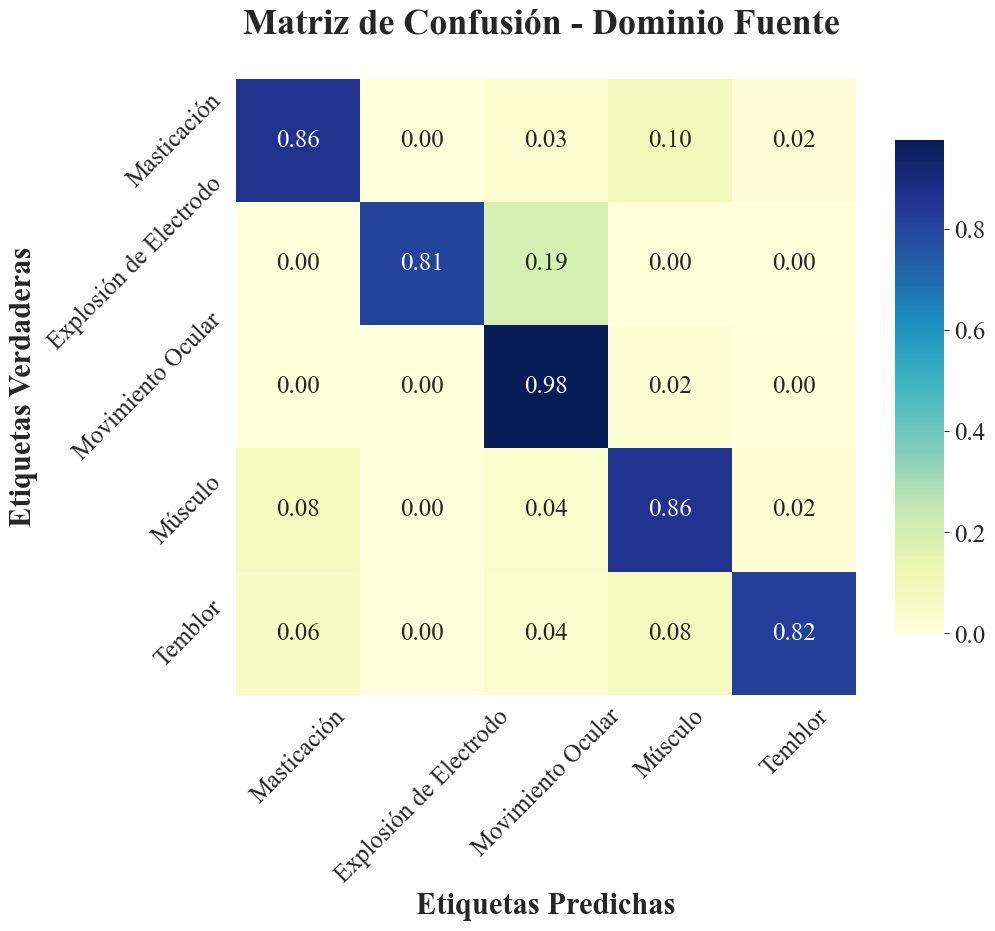

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.86it/s]



Evaluación para el dominio source:
Exactitud General: 0.9110
Precisión General: 0.9214
Sensibilidad General: 0.8881
Puntaje F1 General: 0.9027

Métricas por clase:
Clase Chewing:
  - Exactitud: 0.8619
  - Precisión: 0.8731
  - Sensibilidad: 0.8619
  - Puntaje F1: 0.8675
  - Especificidad: 0.9671
Clase Electrode pop:
  - Exactitud: 0.8056
  - Precisión: 0.9667
  - Sensibilidad: 0.8056
  - Puntaje F1: 0.8788
  - Especificidad: 0.9998
Clase Eye movement:
  - Exactitud: 0.9757
  - Precisión: 0.9083
  - Sensibilidad: 0.9757
  - Puntaje F1: 0.9408
  - Especificidad: 0.9741
Clase Muscle:
  - Exactitud: 0.8631
  - Precisión: 0.8485
  - Sensibilidad: 0.8631
  - Puntaje F1: 0.8558
  - Especificidad: 0.9556
Clase Shiver:
  - Exactitud: 0.8221
  - Precisión: 0.9321
  - Sensibilidad: 0.8221
  - Puntaje F1: 0.8736
  - Especificidad: 0.9911


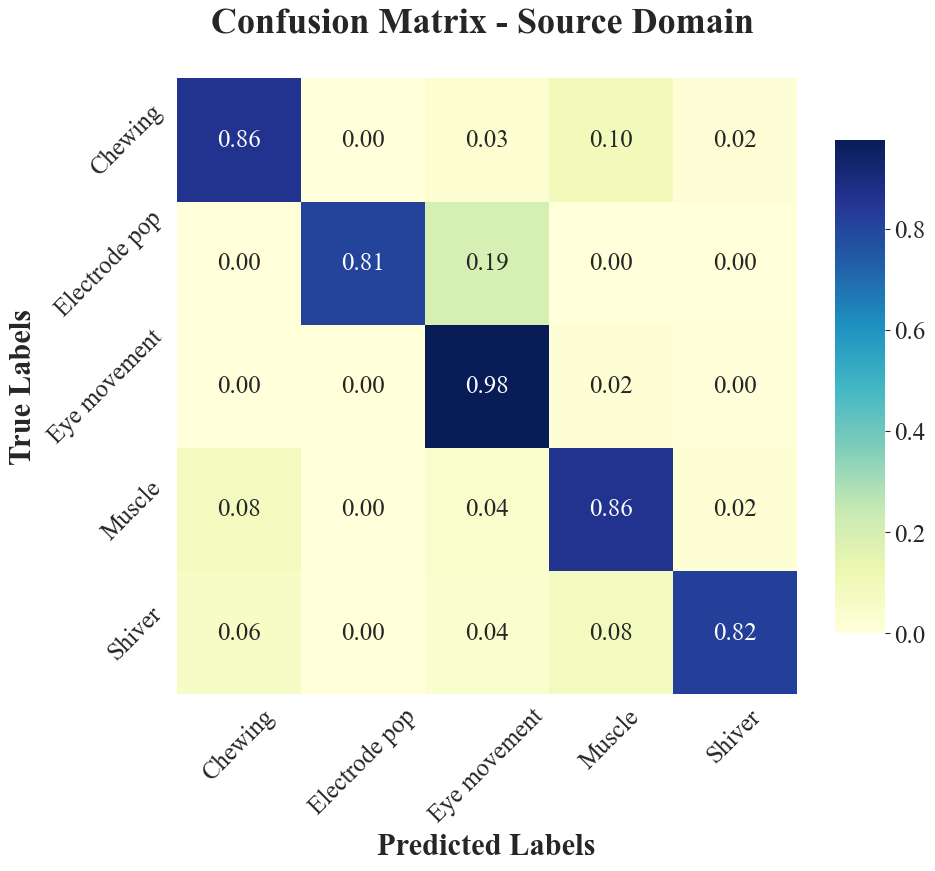

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 519/519 [02:45<00:00,  3.14it/s]



Evaluación para el dominio source:
Exactitud General: 0.9568
Precisión General: 0.9524
Sensibilidad General: 0.9268
Puntaje F1 General: 0.9384

Métricas por clase:
Clase Masticación:
  - Exactitud: 0.9151
  - Precisión: 0.9526
  - Sensibilidad: 0.9151
  - Puntaje F1: 0.9335
  - Especificidad: 0.9882
Clase Explosión de Electrodo:
  - Exactitud: 0.7917
  - Precisión: 0.9135
  - Sensibilidad: 0.7917
  - Puntaje F1: 0.8482
  - Especificidad: 0.9995
Clase Movimiento Ocular:
  - Exactitud: 0.9948
  - Precisión: 0.9296
  - Sensibilidad: 0.9948
  - Puntaje F1: 0.9611
  - Especificidad: 0.9787
Clase Músculo:
  - Exactitud: 0.9490
  - Precisión: 0.9318
  - Sensibilidad: 0.9490
  - Puntaje F1: 0.9403
  - Especificidad: 0.9808
Clase Temblor:
  - Exactitud: 0.9107
  - Precisión: 0.9873
  - Sensibilidad: 0.9107
  - Puntaje F1: 0.9475
  - Especificidad: 0.9982


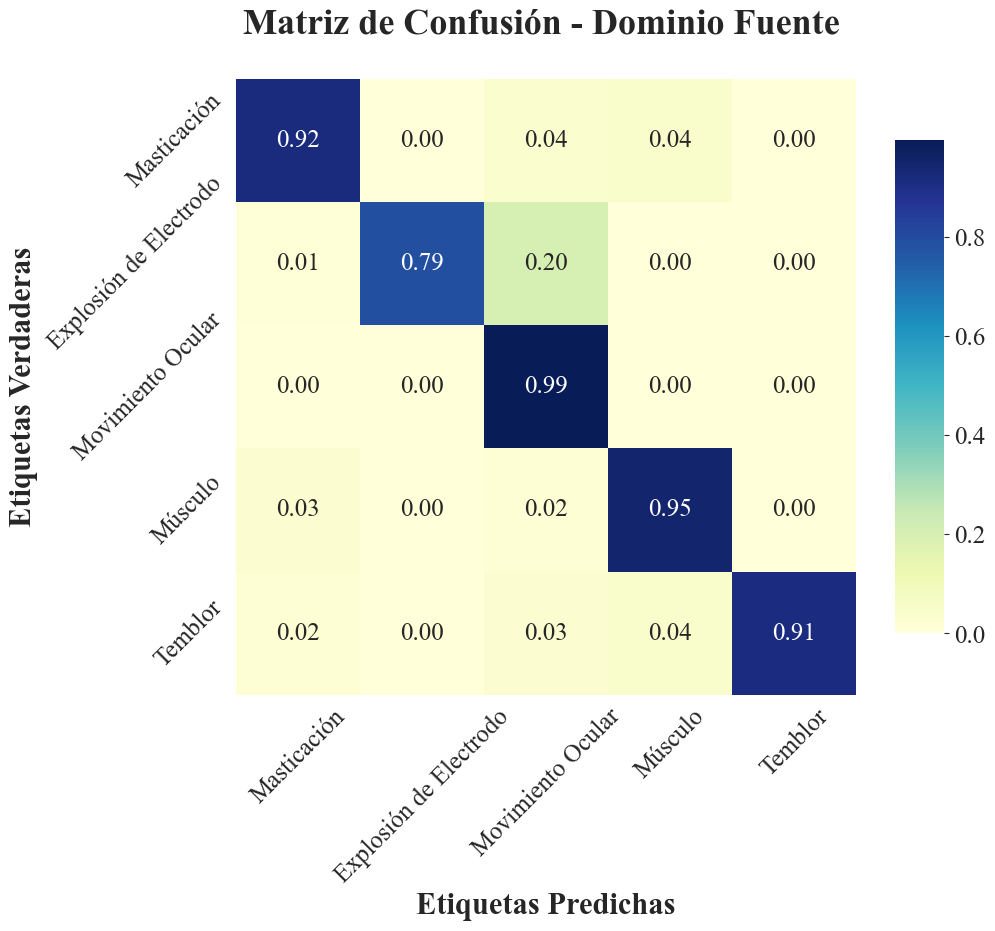

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 519/519 [00:39<00:00, 13.07it/s]



Evaluación para el dominio source:
Exactitud General: 0.9568
Precisión General: 0.9524
Sensibilidad General: 0.9268
Puntaje F1 General: 0.9384

Métricas por clase:
Clase Chewing:
  - Exactitud: 0.9151
  - Precisión: 0.9526
  - Sensibilidad: 0.9151
  - Puntaje F1: 0.9335
  - Especificidad: 0.9882
Clase Electrode pop:
  - Exactitud: 0.7917
  - Precisión: 0.9135
  - Sensibilidad: 0.7917
  - Puntaje F1: 0.8482
  - Especificidad: 0.9995
Clase Eye movement:
  - Exactitud: 0.9948
  - Precisión: 0.9296
  - Sensibilidad: 0.9948
  - Puntaje F1: 0.9611
  - Especificidad: 0.9787
Clase Muscle:
  - Exactitud: 0.9490
  - Precisión: 0.9318
  - Sensibilidad: 0.9490
  - Puntaje F1: 0.9403
  - Especificidad: 0.9808
Clase Shiver:
  - Exactitud: 0.9107
  - Precisión: 0.9873
  - Sensibilidad: 0.9107
  - Puntaje F1: 0.9475
  - Especificidad: 0.9982


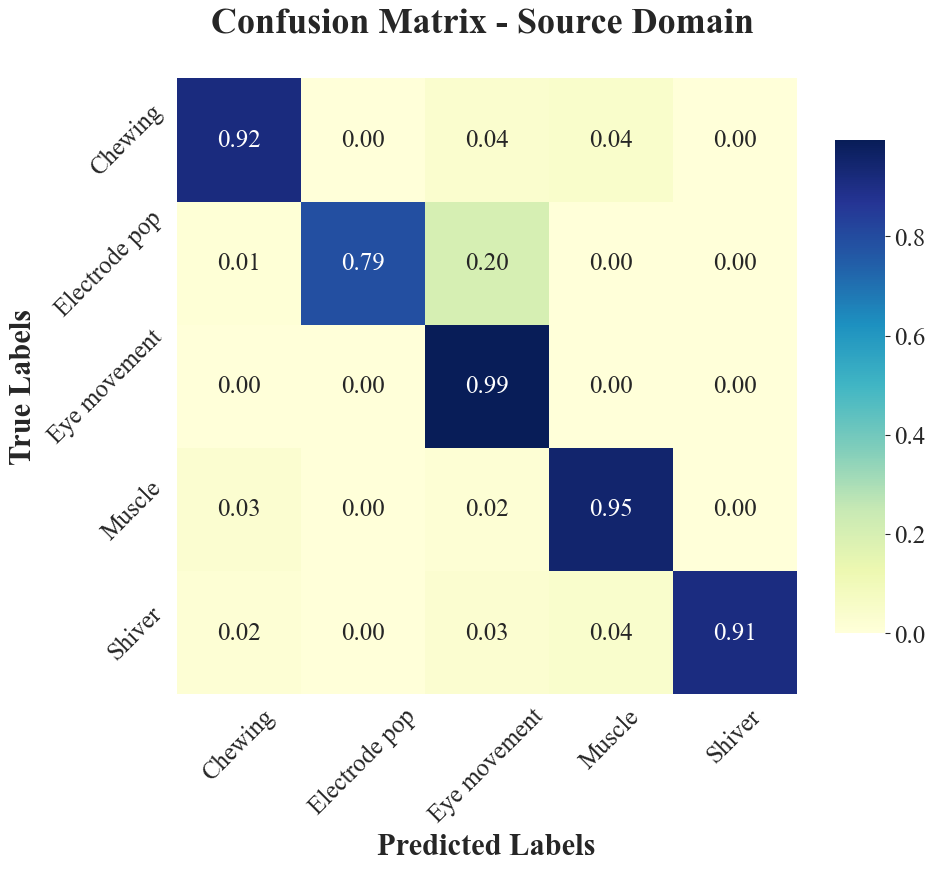

(0.9568154402895054,
 0.9523806269774376,
 0.9268224095712503,
 0.9383587276369116,
 array([0.95259939, 0.91346154, 0.92961351, 0.93181818, 0.98734793]),
 array([0.91509988, 0.79166667, 0.99479595, 0.94896821, 0.91068223]),
 array([0.93347318, 0.84821429, 0.96110082, 0.940315  , 0.94746673]),
 [np.float64(0.9882361870066788),
  np.float64(0.999453219927096),
  np.float64(0.9787299868512646),
  np.float64(0.9808373095274742),
  np.float64(0.9981884057971014)],
 array([[9.15099882e-01, 5.87544066e-04, 3.76028202e-02, 4.28907168e-02,
         3.23149236e-03],
        [8.33333333e-03, 7.91666667e-01, 2.00000000e-01, 0.00000000e+00,
         0.00000000e+00],
        [8.21692687e-04, 2.73897562e-04, 9.94795946e-01, 3.56066831e-03,
         5.47795125e-04],
        [3.03959844e-02, 0.00000000e+00, 1.70105968e-02, 9.48968210e-01,
         3.62520915e-03],
        [1.88509874e-02, 2.69299820e-03, 2.73788151e-02, 4.03949731e-02,
         9.10682226e-01]]))

In [347]:
evaluate_domain(model_source, test_loader, class_names, device, domain='source', language='es')
evaluate_domain(model_source, test_loader, class_names, device, domain='source', language='en')
evaluate_domain(model_source, train_loader, class_names, device, domain='source', language='es')
evaluate_domain(model_source, train_loader, class_names, device, domain='source', language='en')

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 130/130 [00:09<00:00, 13.34it/s]



Evaluación para el dominio target:
Exactitud General: 0.8910
Precisión General: 0.8666
Sensibilidad General: 0.8583
Puntaje F1 General: 0.8619

Métricas por clase:
Clase Masticación:
  - Exactitud: 0.7993
  - Precisión: 0.8314
  - Sensibilidad: 0.7993
  - Puntaje F1: 0.8150
  - Especificidad: 0.9562
Clase Explosión de Electrodo:
  - Exactitud: 0.7222
  - Precisión: 0.7879
  - Sensibilidad: 0.7222
  - Puntaje F1: 0.7536
  - Especificidad: 0.9983
Clase Movimiento Ocular:
  - Exactitud: 0.9444
  - Precisión: 0.9066
  - Sensibilidad: 0.9444
  - Puntaje F1: 0.9251
  - Especificidad: 0.9744
Clase Músculo:
  - Exactitud: 0.8825
  - Precisión: 0.9286
  - Sensibilidad: 0.8825
  - Puntaje F1: 0.9050
  - Especificidad: 0.9804
Clase Temblor:
  - Exactitud: 0.8071
  - Precisión: 0.7836
  - Sensibilidad: 0.8071
  - Puntaje F1: 0.7952
  - Especificidad: 0.9671


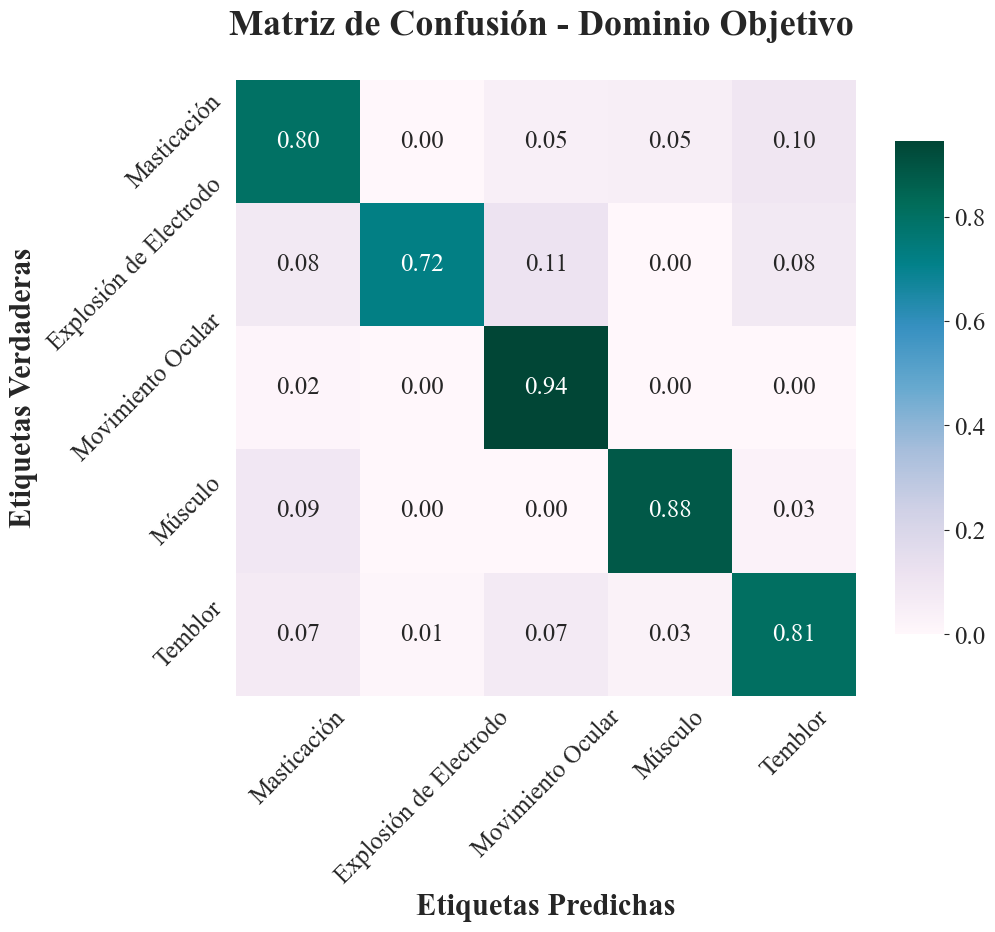

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 130/130 [00:10<00:00, 12.71it/s]



Evaluación para el dominio target:
Exactitud General: 0.8910
Precisión General: 0.8666
Sensibilidad General: 0.8583
Puntaje F1 General: 0.8619

Métricas por clase:
Clase Chewing:
  - Exactitud: 0.7993
  - Precisión: 0.8314
  - Sensibilidad: 0.7993
  - Puntaje F1: 0.8150
  - Especificidad: 0.9562
Clase Electrode pop:
  - Exactitud: 0.7222
  - Precisión: 0.7879
  - Sensibilidad: 0.7222
  - Puntaje F1: 0.7536
  - Especificidad: 0.9983
Clase Eye movement:
  - Exactitud: 0.9444
  - Precisión: 0.9066
  - Sensibilidad: 0.9444
  - Puntaje F1: 0.9251
  - Especificidad: 0.9744
Clase Muscle:
  - Exactitud: 0.8825
  - Precisión: 0.9286
  - Sensibilidad: 0.8825
  - Puntaje F1: 0.9050
  - Especificidad: 0.9804
Clase Shiver:
  - Exactitud: 0.8071
  - Precisión: 0.7836
  - Sensibilidad: 0.8071
  - Puntaje F1: 0.7952
  - Especificidad: 0.9671


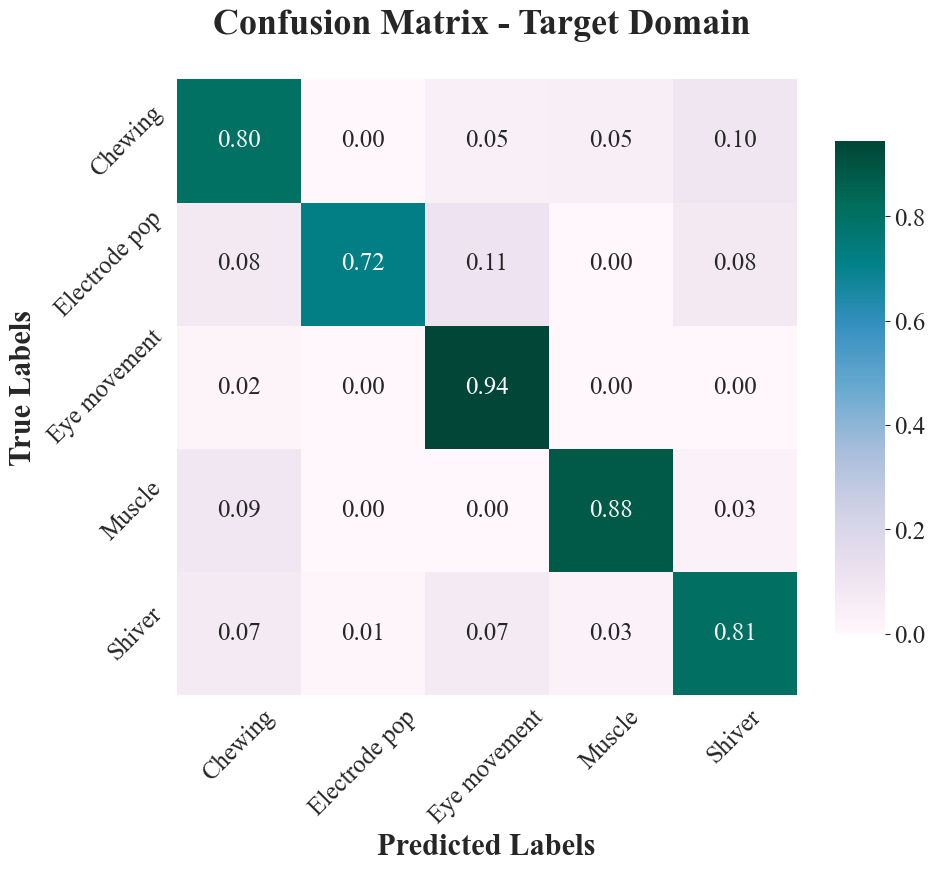

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 519/519 [00:37<00:00, 13.75it/s]



Evaluación para el dominio target:
Exactitud General: 0.9008
Precisión General: 0.8979
Sensibilidad General: 0.8761
Puntaje F1 General: 0.8857

Métricas por clase:
Clase Masticación:
  - Exactitud: 0.8044
  - Precisión: 0.8448
  - Sensibilidad: 0.8044
  - Puntaje F1: 0.8241
  - Especificidad: 0.9621
Clase Explosión de Electrodo:
  - Exactitud: 0.7750
  - Precisión: 0.9208
  - Sensibilidad: 0.7750
  - Puntaje F1: 0.8416
  - Especificidad: 0.9995
Clase Movimiento Ocular:
  - Exactitud: 0.9378
  - Precisión: 0.9197
  - Sensibilidad: 0.9378
  - Puntaje F1: 0.9287
  - Especificidad: 0.9769
Clase Músculo:
  - Exactitud: 0.9024
  - Precisión: 0.9326
  - Sensibilidad: 0.9024
  - Puntaje F1: 0.9172
  - Especificidad: 0.9820
Clase Temblor:
  - Exactitud: 0.8478
  - Precisión: 0.8206
  - Sensibilidad: 0.8478
  - Puntaje F1: 0.8340
  - Especificidad: 0.9712


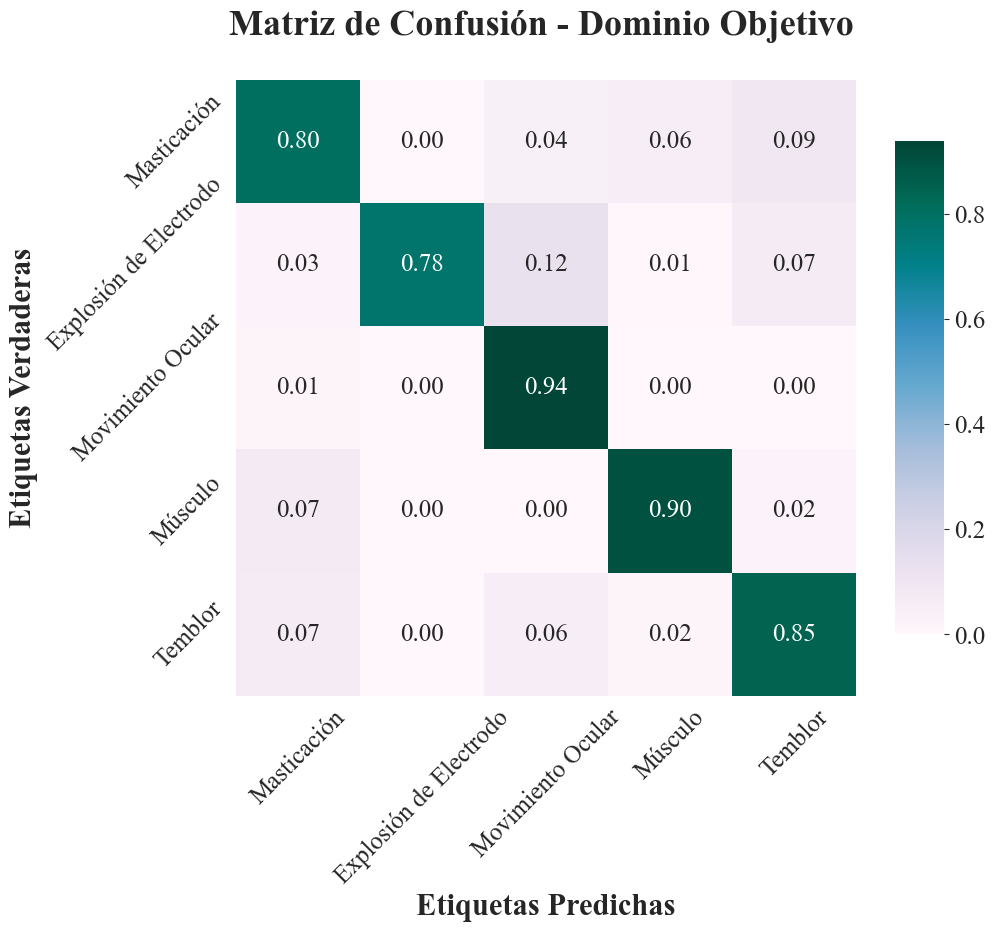

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 519/519 [00:38<00:00, 13.41it/s]



Evaluación para el dominio target:
Exactitud General: 0.9008
Precisión General: 0.8979
Sensibilidad General: 0.8761
Puntaje F1 General: 0.8857

Métricas por clase:
Clase Chewing:
  - Exactitud: 0.8044
  - Precisión: 0.8448
  - Sensibilidad: 0.8044
  - Puntaje F1: 0.8241
  - Especificidad: 0.9621
Clase Electrode pop:
  - Exactitud: 0.7750
  - Precisión: 0.9208
  - Sensibilidad: 0.7750
  - Puntaje F1: 0.8416
  - Especificidad: 0.9995
Clase Eye movement:
  - Exactitud: 0.9378
  - Precisión: 0.9197
  - Sensibilidad: 0.9378
  - Puntaje F1: 0.9287
  - Especificidad: 0.9769
Clase Muscle:
  - Exactitud: 0.9024
  - Precisión: 0.9326
  - Sensibilidad: 0.9024
  - Puntaje F1: 0.9172
  - Especificidad: 0.9820
Clase Shiver:
  - Exactitud: 0.8478
  - Precisión: 0.8206
  - Sensibilidad: 0.8478
  - Puntaje F1: 0.8340
  - Especificidad: 0.9712


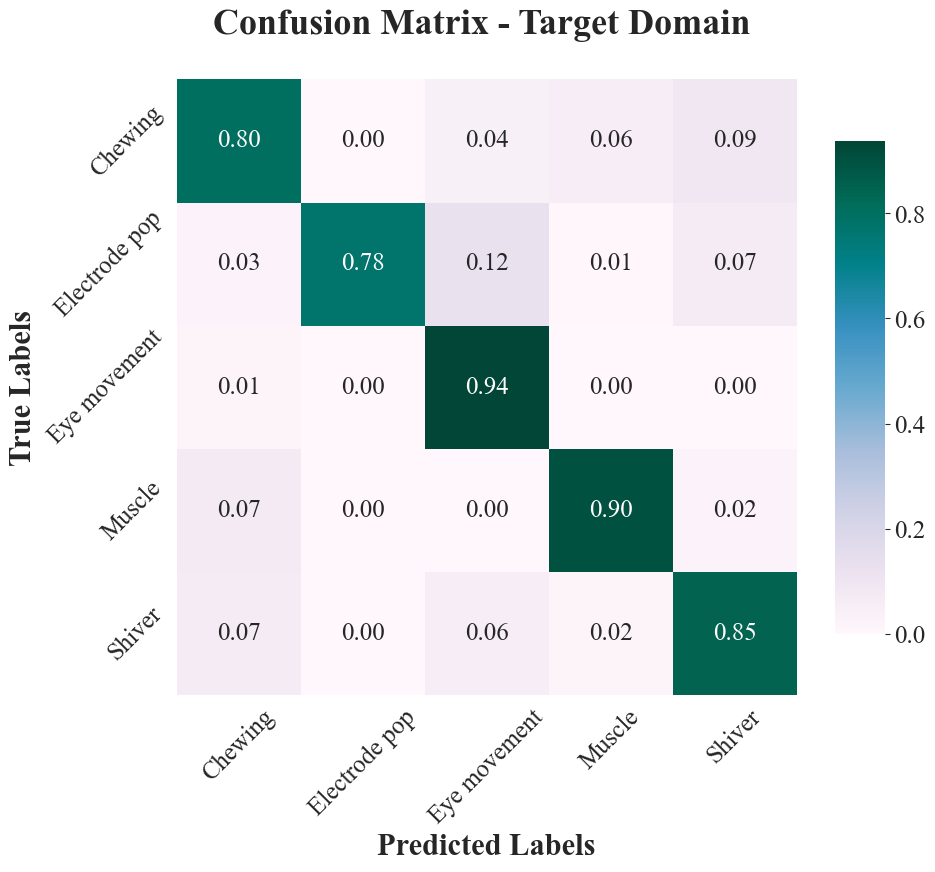

(0.9007840772014475,
 0.8979470253334259,
 0.8760608881026629,
 0.8857158619519468,
 array([0.84481688, 0.92079208, 0.91968842, 0.93256484, 0.82059079]),
 array([0.80437352, 0.775     , 0.93782525, 0.90239822, 0.8478456 ]),
 array([0.8240993 , 0.84162896, 0.92866829, 0.91723356, 0.83399558]),
 [np.float64(0.9621097302212792),
  np.float64(0.9995139732685298),
  np.float64(0.9768736947946477),
  np.float64(0.9819916884716022),
  np.float64(0.9712235228539576)],
 array([[8.04373522e-01, 5.91016548e-04, 4.19621749e-02, 5.64420804e-02,
         9.21985816e-02],
        [2.50000000e-02, 7.75000000e-01, 1.25000000e-01, 8.33333333e-03,
         6.66666667e-02],
        [1.47904684e-02, 2.73897562e-04, 9.37825253e-01, 0.00000000e+00,
         3.56066831e-03],
        [7.41773564e-02, 0.00000000e+00, 1.11544897e-03, 9.02398215e-01,
         2.23089794e-02],
        [6.73249551e-02, 2.24416517e-03, 5.78994614e-02, 1.70556553e-02,
         8.47845601e-01]]))

In [348]:
evaluate_domain(model_target, test_loader, class_names, device, domain='target', language='es')
evaluate_domain(model_target, test_loader, class_names, device, domain='target', language='en')
evaluate_domain(model_target, train_loader, class_names, device, domain='target', language='es')
evaluate_domain(model_target, train_loader, class_names, device, domain='target', language='en')

In [291]:
sns.set_style("darkgrid")

def plot_training_metrics(csv_path, language='en', save_path=None, y_min=0.0, y_max=1.0):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(10, 6))
    
    if language == 'es':
        plt.plot(df.index, df['Train Source Acc'], label='Exactitud de Entrenamiento (Fuente)', 
                 linewidth=1, linestyle='-', marker='x', markersize=5)
        plt.plot(df.index, df['Train Target Acc'], label='Exactitud de Entrenamiento (Objetivo)', 
                 linewidth=1, linestyle='--', marker='s', markersize=5)
        plt.plot(df.index, df['Val Source Acc'], label='Exactitud de Validación (Fuente)', 
                 linewidth=1, linestyle='-.', marker='^', markersize=5)
        plt.plot(df.index, df['Val Target Acc'], label='Exactitud de Validación (Objetivo)', 
                 linewidth=1, linestyle=':', marker='d', markersize=5)
        
        plt.title('Entrenamiento y Validación de Exactitud\n', fontsize=18, fontweight='bold')
        plt.xlabel('Épocas', fontsize=18, fontweight='bold')
        plt.ylabel('Exactitud', fontsize=18, fontweight='bold')
    else:
        plt.plot(df.index, df['Train Source Acc'], label='Training Accuracy (Source)', 
                 linewidth=1, linestyle='-', marker='x', markersize=5)
        plt.plot(df.index, df['Train Target Acc'], label='Training Accuracy (Target)', 
                 linewidth=1, linestyle='--', marker='s', markersize=5)
        plt.plot(df.index, df['Val Source Acc'], label='Validation Accuracy (Source)', 
                 linewidth=1, linestyle='-.', marker='^', markersize=5)
        plt.plot(df.index, df['Val Target Acc'], label='Validation Accuracy (Target)', 
                 linewidth=1, linestyle=':', marker='d', markersize=5)
        
        plt.title('Training and Validation Accuracy\n', fontsize=18, fontweight='bold')
        plt.xlabel('Epochs', fontsize=18, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=18, fontweight='bold')
    
    plt.ylim(0.5, 1)
    plt.xticks(ticks=range(0, len(df.index) + 1, 5), fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='lower right', fontsize=14, labelspacing=1.5, borderpad=1.5, frameon=True, fancybox=True)
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


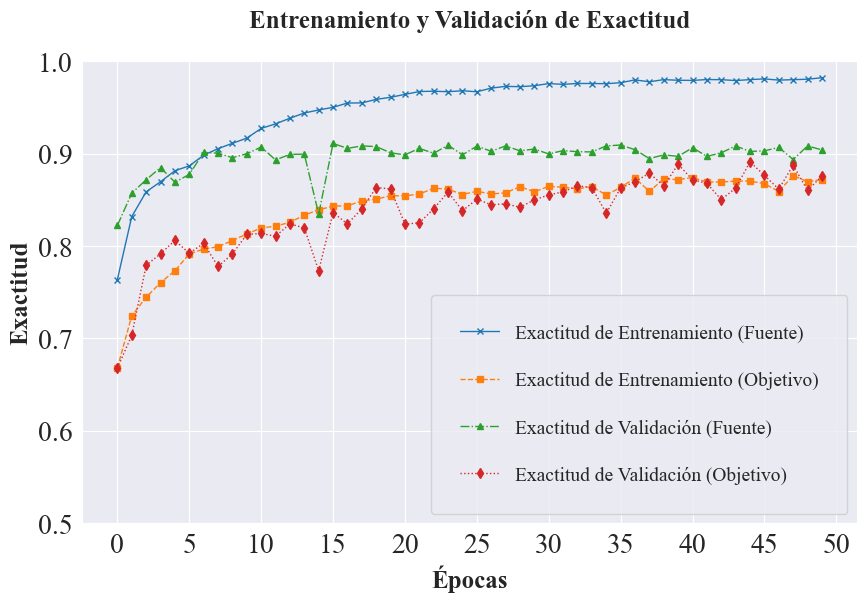

In [292]:
plot_training_metrics('training_metrics_stft.csv', language='es')

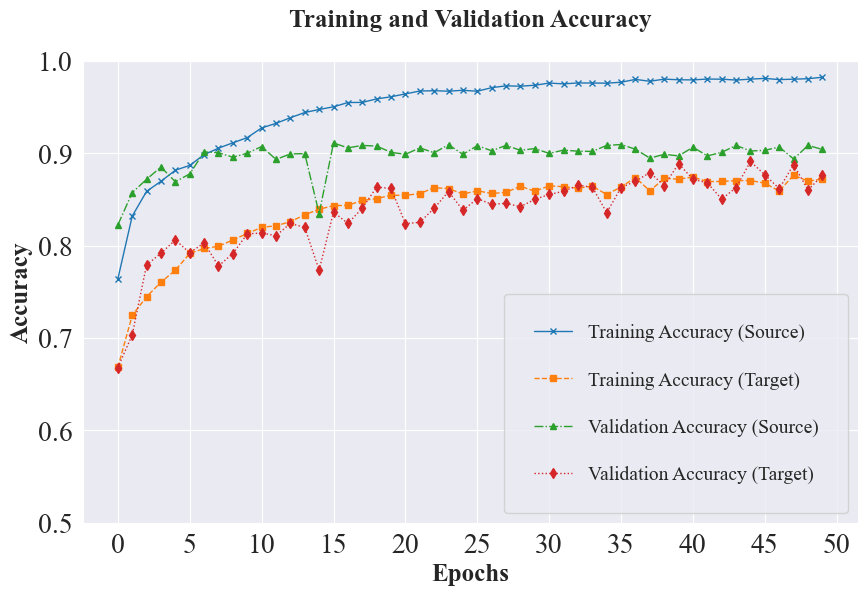

In [293]:
plot_training_metrics('training_metrics_stft.csv', language='en')

In [294]:
def plot_domain_adaptation_loss(csv_path, language='en', save_path=None):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    
    plt.figure(figsize=(10, 6))
    
    if language == 'es':
        plt.plot(df.index, df['Train Loss'], label='Pérdida de Adaptación de Dominio', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.title('Pérdida de Adaptación de Dominio\n', fontsize=18, fontweight='bold')
        plt.xlabel('Épocas', fontsize=18, fontweight='bold')
        plt.ylabel('Pérdida', fontsize=18, fontweight='bold')
    else:
        plt.plot(df.index, df['Train Loss'], label='Domain Adaptation Loss', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.title('Domain Adaptation Loss\n', fontsize=18, fontweight='bold')
        plt.xlabel('Epochs', fontsize=18, fontweight='bold')
        plt.ylabel('Loss', fontsize=18, fontweight='bold')
    
    plt.xticks(ticks=range(0, len(df.index) + 1, 5), fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='upper right', fontsize=18)
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

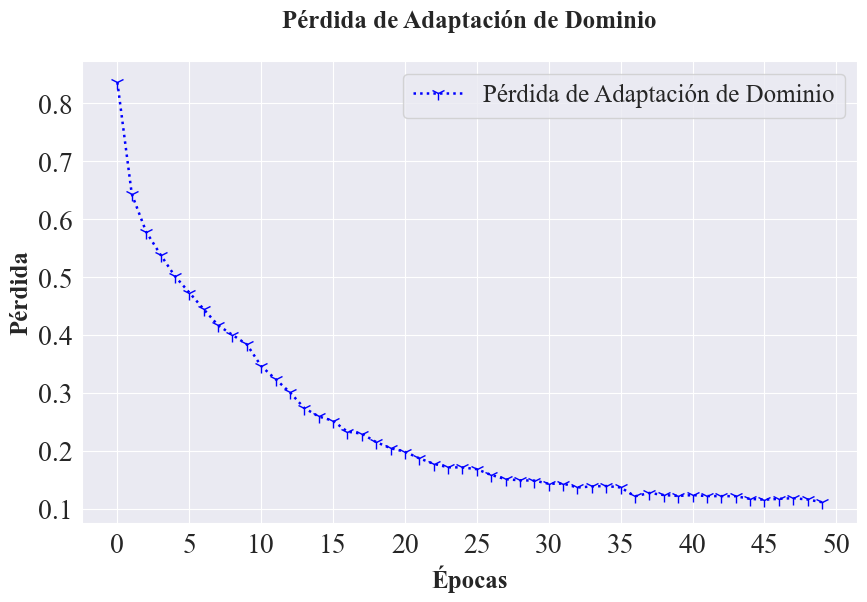

In [295]:
plot_domain_adaptation_loss('training_metrics_stft.csv', language='es')

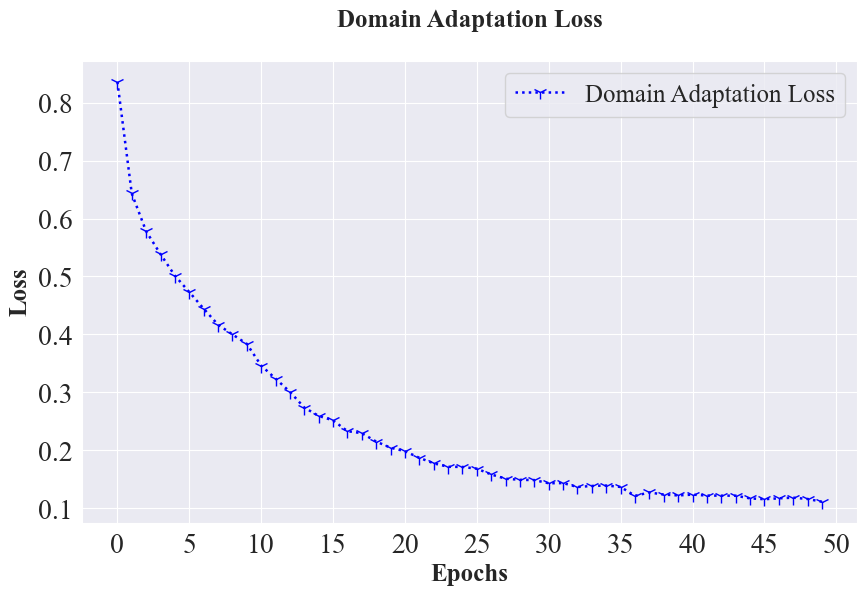

In [296]:
plot_domain_adaptation_loss('training_metrics_stft.csv', language='en')